# Cursive English Handwritten Character Classification: Exploratory Data Analysis
# ------------------------------------------------------------------------------

### Notebook Overview:
This notebook will be used to explore and understand the cursive handwriting dataset derived from the CVL database. We will be:
1. Previewing Dataset
2. Check Data Quality and Clean
3. Class Distribution Analysis
4. Visual Explorations
5. Statistical Summaries
6. Preliminary Feature or Embedding Analysis
7. EDA Conclusion

In [2]:
%pip install torchsummary pytest
%pip install pandas matplotlib seaborn pillow torchvision scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torchvision.transforms as transforms
from PIL import Image

import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import confusion_matrix, classification_report
from importlib import reload

# Checking if CUDA is available
flag_cuda = torch.cuda.is_available()

if flag_cuda:
    print("Using GPU")
else:
    print("Using CPU")

Using CPU


## 1. Preview the Data
### In this section, we will:
### 1. Examine the folder structure for our dataset.
### 2. Count how many files are in each subdirectory.
### 3. Visualize a few random images from the `lines`, `pages`, and `words` directories.

Folder Structure and File Counts:
- words: 99592 files found
Displaying random images from 'words' folder:


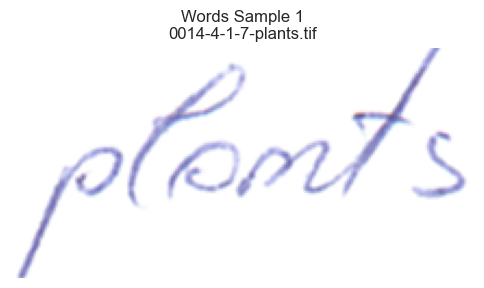

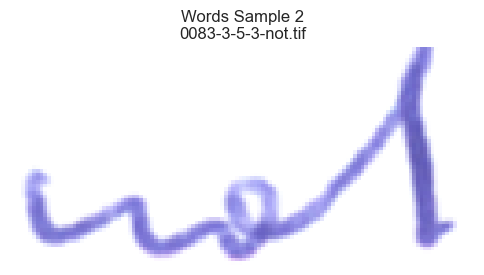

In [4]:
import os
import glob
import random
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

# Base path for the raw dataset
BASE_PATH = os.path.normpath('cvl-database-1-1/raw_dataset')

# Since only the words folder exists now, we use that:
subfolders = ['words']

print("Folder Structure and File Counts:")
for folder in subfolders:
    folder_path = os.path.join(BASE_PATH, folder)
    all_files = glob.glob(os.path.join(folder_path, '**', '*.*'), recursive=True)
    print(f"- {folder}: {len(all_files)} files found")

def show_random_image(folder_name, num_samples=1):
    """
    Display 'num_samples' random images from the specified folder (including its subfolders).
    """
    folder_path = os.path.join(BASE_PATH, folder_name)
    # Adjust file extension as needed (here using .tif)
    image_files = glob.glob(os.path.join(folder_path, '**', '*.tif'), recursive=True)
    if not image_files:
        print(f"No image files found in '{folder_path}'.")
        return
    random_files = random.sample(image_files, k=min(num_samples, len(image_files)))
    for i, file_path in enumerate(random_files, 1):
        img = Image.open(file_path)
        plt.figure(figsize=(6, 4))
        plt.imshow(img, cmap='gray')  # Adjust cmap if images are RGB.
        plt.title(f"{folder_name.capitalize()} Sample {i}\n{os.path.basename(file_path)}")
        plt.axis('off')
        plt.show()

for folder_name in subfolders:
    print(f"Displaying random images from '{folder_name}' folder:")
    show_random_image(folder_name, num_samples=2)


# 2. Data Quality and Cleaning

In [5]:
import os
import glob
import re

# Base path for the raw dataset
BASE_PATH = os.path.normpath('cvl-database-1-1/raw_dataset')

def filter_german_files(folder_name, extension='tif'):
    folder_path = os.path.join(BASE_PATH, folder_name)
    all_files = glob.glob(os.path.join(folder_path, '**', f'*.{extension}'), recursive=True)
    all_files = [os.path.normpath(f) for f in all_files]

    # Filter out files where the base name contains '-6-'
    filtered_files = [f for f in all_files if not re.search(r'-6-', os.path.basename(f))]
    print(f"Folder: {folder_name} - Original count: {len(all_files)}, Filtered count: {len(filtered_files)}")
    return filtered_files

# Process the 'words' folder only
words_filtered = filter_german_files('words')

Folder: words - Original count: 99592, Filtered count: 68968


In [6]:
from PIL import Image, ImageOps
import os

def resize_image_to_uniform_size(image_path, target_width, target_height):
    # Open the image
    img = Image.open(image_path)
    current_width, current_height = img.size
    # Calculate padding to center the image within the target dimensions
    padding_left = (target_width - current_width) // 2
    padding_top = (target_height - current_height) // 2
    padding_right = target_width - current_width - padding_left
    padding_bottom = target_height - current_height - padding_top
    # Add padding with a white background (RGB white: 255, 255, 255)
    padded_img = ImageOps.expand(img, (padding_left, padding_top, padding_right, padding_bottom), (255, 255, 255))
    return padded_img

def process_images_in_folder(file_list, target_width, target_height, output_path):
    # Ensure the output directory exists
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    # Process each file in the list
    for filename in file_list:
        if filename.lower().endswith('.tif'):
            padded_image = resize_image_to_uniform_size(filename, target_width, target_height)
            output_path_save = os.path.join(output_path, os.path.basename(filename))
            padded_image.save(output_path_save)

# Define the output path under preprocessed_dataset
words_output_folder = os.path.normpath(os.path.join('cvl-database-1-1', 'preprocessed_dataset', 'words_padded'))

# Set the target size (these values are based on your stats)
target_width = 1756  # Largest width from the stats
target_height = 146  # Largest height from the stats

# Process all .tif images in the 'words' folder
process_images_in_folder(words_filtered, target_width, target_height, words_output_folder)

# 3. Loading the Data and Perform Split

In [7]:
import words_helper as wp

classes, train_loader, valid_loader, test_loader, label_dict = wp.createLoaders()
print("Unique classes in dataset:")
for c in classes:
    print(c)

Done creating loaders
Done creating loaders
Unique classes in dataset:
1955
Alas
American
And
Austrian
Binär
Disdaining
European
For
Heinz
Hexagons
House
I
If
Imagine
It
Like
Lines
Mailüfterl
Nomacs
Now
Pentagons
Rechenautomat
Show'd
Squares
Technology
The
Till
Triangles
Typhoon
University
Unknown
Usher
Vienna
When
Which
While
Whirlwind
Wiener
You
Zemanek
a
about
above
ace
achieve
ago
all
all's
an
and
angles
animals
any
are
art
as
asunder
at
ating
ation
automat
away
be
because
been
below
bloody
brain
brandish'd
brave
breath
builder
built
burst
but
by
calculation
came
can
carved
closed
computer
correct
country
countrymen
cultivated
curiosity
cution
daining
damned
dank
deep
deserves
dezimaler
differ
dish'd
do
don't
dows
dreams
each
edges
effect
enough
entire
erally
erating
even
execution
face
faced
feet
few
fierce
figures
first
fissure
fixed
for
fortune
fragments
freely
from
full
gave
gazed
generally
genius
gons
great
had
hard
has
have
he
higher
his
imagination
imaler
in
individuals
ing


# 4. Class Distribution Analysis

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_classes_distribution(loader, split_name="Train", label_dict=None, classes_list=None):
    # Collect all labels from the loader
    labels_list = []
    for _, labels in loader:
        labels_list.extend(labels)
    
    # Create a DataFrame with the labels
    data = pd.DataFrame({"label": labels_list})
    label_counts = data["label"].value_counts()
    total_samples = len(data)
    
    print(f"Class Distribution for {split_name} set:")
    for label, count in label_counts.items():
        percent = (count / total_samples) * 100
        # If label_dict and classes_list are provided, map the raw label to the desired display label.
        if label_dict is not None and classes_list is not None:
            try:
                idx = classes_list.index(label)
                display_label = label_dict[idx]
            except ValueError:
                display_label = label  # fallback if label not found in the list
        else:
            display_label = label
        print("{:<20s}:   {} or {:.1f}%".format(display_label, count, percent))
    print()

def plot_label_per_class(loader, split_name="Train", label_dict=None, classes_list=None):
    # Collect labels for plotting
    labels_list = []
    for _, labels in loader:
        labels_list.extend(labels)
    
    data = pd.DataFrame({"label": labels_list})
    
    # To order the plot according to counts
    order = data["label"].value_counts().index
    plt.figure(figsize=(12, 4))
    g = sns.countplot(x="label", data=data, order=order)
    g.set_title(f"Number of labels for each class in {split_name} set")
    
    # Annotate each bar with the display label using label_dict if provided.
    for p, raw_label in zip(g.patches, order):
        if label_dict is not None and classes_list is not None:
            try:
                idx = classes_list.index(raw_label)
                display_label = label_dict[idx]
            except ValueError:
                display_label = raw_label
        else:
            display_label = raw_label
        g.annotate(display_label, (p.get_x(), p.get_height()+0.1))
    plt.show()


# Example usage:
# Assuming you have created your loaders as follows:
# classes, train_loader, valid_loader, test_loader, label_dict = createLoaders(batch_size=128)

# Now, print and plot class distributions using the label dictionary:
get_classes_distribution(train_loader, "Train", label_dict=label_dict, classes_list=classes)
get_classes_distribution(valid_loader, "Validation", label_dict=label_dict, classes_list=classes)
get_classes_distribution(test_loader, "Test", label_dict=label_dict, classes_list=classes)

plot_label_per_class(train_loader, "Train", label_dict=label_dict, classes_list=classes)
plot_label_per_class(valid_loader, "Validation", label_dict=label_dict, classes_list=classes)
plot_label_per_class(test_loader, "Test", label_dict=label_dict, classes_list=classes)

Class Distribution for Train set:
of                  :   2103 or 4.4%
the                 :   1858 or 3.8%
a                   :   1282 or 2.7%
on                  :   1177 or 2.4%
and                 :   886 or 1.8%
or                  :   865 or 1.8%
is                  :   787 or 1.6%
in                  :   692 or 1.4%
his                 :   589 or 1.2%
my                  :   588 or 1.2%
variety             :   578 or 1.2%
but                 :   543 or 1.1%
with                :   532 or 1.1%
it                  :   498 or 1.0%
fortune             :   436 or 0.9%
to                  :   429 or 0.9%
computer            :   404 or 0.8%
name                :   399 or 0.8%
like                :   398 or 0.8%
an                  :   395 or 0.8%
which               :   387 or 0.8%
Mailüfterl          :   384 or 0.8%
The                 :   383 or 0.8%
first               :   381 or 0.8%
much                :   381 or 0.8%
that                :   377 or 0.8%
individuals         :   37

KeyboardInterrupt: 

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import words_helper as wp

classes, train_loader, valid_loader, test_loader, label_dict = wp.createLoaders()
# Define a simple convolutional layer.
# Here we use a 3x3 kernel with padding=1 so that the spatial dimensions remain the same.
conv_layer = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)

# Optionally, move the layer to GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv_layer.to(device)

def create_convolution_matrix(loader, conv_layer):
    """
    Apply the convolution layer to every batch from the loader and return a list of feature maps.

    Parameters:
        loader: DataLoader for the training set.
        conv_layer: A convolution layer (e.g., nn.Conv2d) to apply to the images.

    Returns:
        A list of tensors containing the convolution outputs (feature maps) for each batch.
    """
    conv_layer.eval()  # Set the layer to evaluation mode
    feature_maps = []
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            out = conv_layer(images)
            feature_maps.append(out.cpu())
    return feature_maps

# Create convolution matrices for the training set.
# (train_loader is assumed to be created via your createLoaders function.)
conv_matrices = create_convolution_matrix(train_loader, conv_layer)

# Print out information about the processed data.
print("Number of batches processed:", len(conv_matrices))
if len(conv_matrices) > 0:
    print("Shape of feature maps for first batch:", conv_matrices[0].shape)
    # For example, the shape is: (batch_size, 16, H, W)

# Display one sample feature map from the first image in the first batch.
# We display the first channel of the first image.
sample_feature_map = conv_matrices[0][0, 0]  # first image, first channel
plt.figure(figsize=(4, 4))
plt.imshow(sample_feature_map.numpy(), cmap='gray')
plt.title("Sample Feature Map (Channel 0 of First Image)")
plt.axis("off")
plt.show()


NameError: name 'train_loader' is not defined